In [1]:
import pandas as pd
# coding: UTF-8
import time
import torch
import numpy as np
import torch.utils.data as data
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
from torch.utils.data import SubsetRandomSampler
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from units import *

### 数据预处理

In [2]:
rawdata=pd.read_excel("../backup/arousal_record.xlsx")
rawdata=rawdata[['collect_count','create_time','digg_count','duration','follower_count','gender','share_count','keyword','comment_get','comment_count','intention_counts','variation','arousal']]
rawdata=rawdata[rawdata['variation'].notna()]
rawdata=rawdata[rawdata['arousal'].notna()]
def keyword_encode(keyword):
    if "运动" in keyword:
        return 0
    elif "健身" in keyword:
        return 1
    elif "减肥" in keyword:
        return 2
    elif "自律" in keyword:
        return 3
rawdata['keyword']=rawdata['keyword'].apply(keyword_encode) # 非数字编码
rawdata.fillna(0) # 空值填充0
rawdata['intention_counts']=rawdata['intention_counts']/rawdata['comment_get']
rawdata.drop('comment_get',axis=1)
columns=['collect_count', 'create_time','duration',
       'follower_count', 'gender', 'share_count', 'keyword','comment_count',
        'variation', 'arousal' ,'digg_count', 'intention_counts']
rawdata=rawdata[columns]
rawdata

,collect_count,create_time,duration,follower_count,gender,share_count,keyword,comment_count,variation,arousal,digg_count,intention_counts
0,824,1584363784,36987,1030322,2.0,1467,0,1377,0.089440,-0.819733,29483,0.025641
1,88,1637059817,30973,448197,2.0,31,0,68,0.179454,0.905920,3952,0.050000
2,27,1630749155,48411,3984,2.0,34,0,55,0.291389,-0.252191,212,0.083333
3,236,1600253166,62227,2391833,1.0,299,0,304,0.243002,-0.756444,30626,0.025000
4,1767,1650874861,23180,1167810,1.0,2971,0,1155,0.074048,-0.630283,25549,0.050000
...,...,...,...,...,...,...,...,...,...,...,...,...
628,3,1670846151,13867,2145,0.0,11,1,135,0.231021,-0.713881,602,0.027027
630,15,1670320521,23434,1251689,0.0,25,1,65,0.231210,-0.893198,590,0.052632
631,31,1672723719,12234,21474,0.0,17,1,83,0.171536,-0.753084,487,0.058824
632,11,1668948173,163234,29083,0.0,75,1,162,0.167735,-0.605244,435,0.025000


### 数据归一化

In [3]:
scaler = MinMaxScaler() #实例化
rawdata = scaler.fit_transform(rawdata) #fit，在这里本质是生成min(x)和max(x)
rawdata = pd.DataFrame(rawdata,columns=columns)
rawdata.fillna(0)

,collect_count,create_time,duration,follower_count,gender,share_count,keyword,comment_count,variation,arousal,digg_count,intention_counts
0,0.002157,0.347888,0.015447,0.041407,1.0,0.009141,0.000000,0.014353,0.014550,0.027401,0.019811,0.002849
1,0.000230,0.732670,0.011998,0.018011,1.0,0.000193,0.000000,0.000659,0.030780,0.671033,0.002648,0.111111
2,0.000071,0.686590,0.021999,0.000159,1.0,0.000212,0.000000,0.000523,0.050963,0.239082,0.000134,0.259259
3,0.000618,0.463911,0.029923,0.096126,0.5,0.001863,0.000000,0.003128,0.042239,0.051006,0.020579,0.000000
4,0.004625,0.833546,0.007528,0.046933,0.5,0.018512,0.000000,0.012031,0.011775,0.098062,0.017166,0.111111
...,...,...,...,...,...,...,...,...,...,...,...,...
588,0.000008,0.979374,0.002186,0.000085,0.0,0.000069,0.333333,0.001360,0.040078,0.066881,0.000397,0.009009
589,0.000039,0.975536,0.007674,0.050304,0.0,0.000156,0.333333,0.000628,0.040112,0.000000,0.000389,0.122807
590,0.000081,0.993084,0.001250,0.000862,0.0,0.000106,0.333333,0.000816,0.029353,0.052260,0.000319,0.150327
591,0.000029,0.965515,0.087856,0.001167,0.0,0.000467,0.333333,0.001642,0.028668,0.107401,0.000284,0.000000


### 划分数据集

In [4]:
X_train, X_test, y_train, y_test = train_test_split(rawdata.iloc[:,:-2], rawdata.iloc[:,-1], test_size=0.20)

In [5]:
from sklearn.model_selection import cross_val_score
model = XGBRegressor()
model.fit(X_train,y_train)
scores = model.score(X_test,y_test)
scores
# print(scores,'平均精度',sum(scores)/10)                                          

-0.30451892956400317

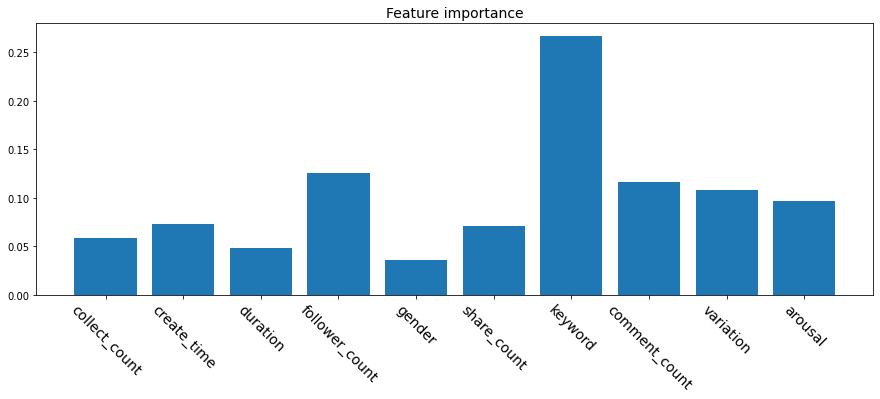

In [6]:
# 获取feature importance
import matplotlib.pyplot as plt
cols=rawdata.iloc[:,:-2].columns
plt.figure(figsize=(15, 5))
plt.bar(range(len(cols)), model.feature_importances_)
plt.xticks(range(len(cols)), cols, rotation=-45, fontsize=14)
plt.title('Feature importance', fontsize=14)
plt.show()

In [7]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(rawdata.iloc[:,:-2][cols])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


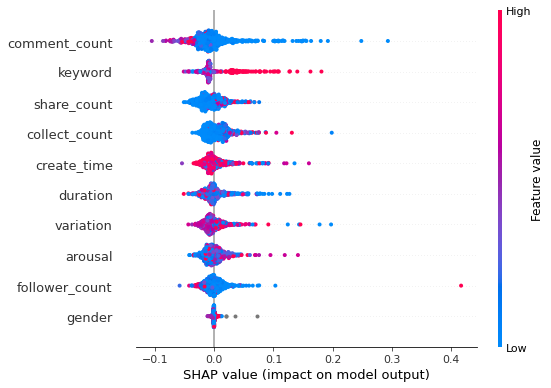

In [8]:
shap.summary_plot(shap_values, rawdata.iloc[:,:-2][cols])

### 分类

In [2]:
rawdata=pd.read_excel("../backup/arousal_record.xlsx")
rawdata=rawdata[['collect_count','create_time','digg_count','duration','follower_count','gender','share_count','keyword','comment_get','comment_count','intention_counts','variation','arousal']]
rawdata=rawdata[rawdata['variation'].notna()]
rawdata=rawdata[rawdata['arousal'].notna()]
def keyword_encode(keyword):
    if "运动" in keyword:
        return 0
    elif "健身" in keyword:
        return 1
    elif "减肥" in keyword:
        return 2
    elif "自律" in keyword:
        return 3
rawdata['keyword']=rawdata['keyword'].apply(keyword_encode) # 非数字编码
rawdata.fillna(0) # 空值填充0
rawdata.drop('comment_get',axis=1)
columns=['collect_count', 'create_time','duration',
       'follower_count', 'gender', 'share_count', 'keyword','comment_count',
        'variation', 'arousal' ,'digg_count', 'intention_counts']
rawdata=rawdata[columns]
rawdata=rawdata.replace('NA',0)
rawdata['intention_counts'][rawdata['intention_counts']==1]=0
rawdata['intention_counts'][rawdata['intention_counts']>1]=1
rawdata=rawdata.dropna()
x=rawdata.iloc[:,:-1]
y=rawdata.iloc[:,-1]

/tmp/ipykernel_745976/2736215368.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rawdata['intention_counts'][rawdata['intention_counts']==1]=0
/tmp/ipykernel_745976/2736215368.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rawdata['intention_counts'][rawdata['intention_counts']>1]=1


In [3]:
scaler = MinMaxScaler() #实例化
x = scaler.fit_transform(x) #fit，在这里本质是生成min(x)和max(x)
x = pd.DataFrame(x)

In [4]:
y.value_counts()

0    442
1    147
Name: intention_counts, dtype: int64

In [5]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.20)
dataset=X_train, y_train, X_test, y_test

BaseLine : XGBoost
Running time: 0.1637587547302246 Seconds


,Positive,Negative,accuracy,macro avg,weighted avg
precision,0.82,0.47,0.76,0.65,0.74
recall,0.89,0.33,0.76,0.61,0.76
f1-score,0.85,0.39,0.76,0.62,0.75
support,91.00,27.00,0.76,118.00,118.00


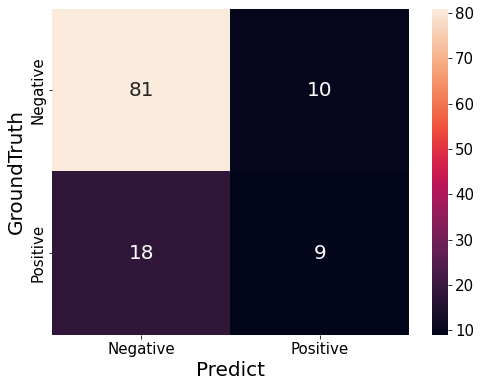

,BaslineName,Accuracy,Precision,MCC,PPV,NPV,Recall,F1,Time,TP,FP,TN,FN
0,XGBoost,0.762712,0.473684,0.255373,0.473684,0.818182,0.333333,0.391304,0.16,9,10,81,18


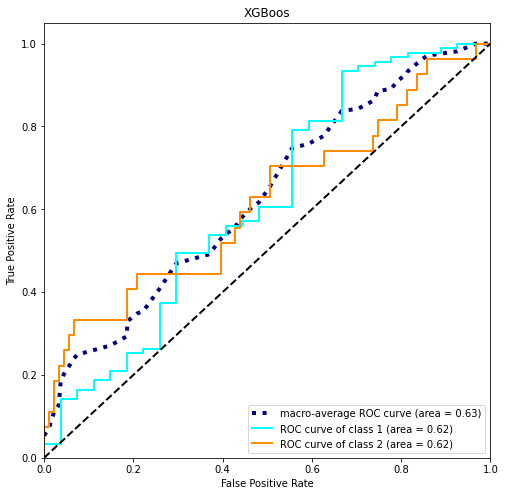

BaseLine : NaiveBayes
Running time: 0.007732391357421875 Seconds


,Positive,Negative,accuracy,macro avg,weighted avg
precision,0.79,0.26,0.57,0.53,0.67
recall,0.59,0.48,0.57,0.54,0.57
f1-score,0.68,0.34,0.57,0.51,0.60
support,91.00,27.00,0.57,118.00,118.00


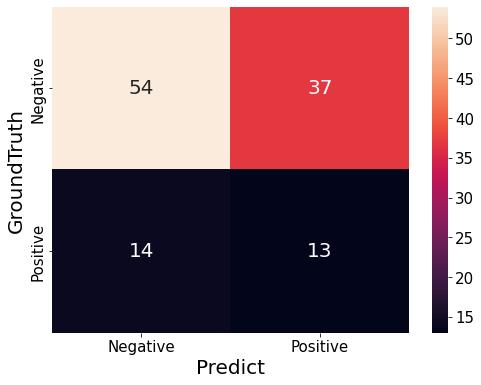

,BaslineName,Accuracy,Precision,MCC,PPV,NPV,Recall,F1,Time,TP,FP,TN,FN
0,NaiveBayes,0.567797,0.26,0.063661,0.26,0.794118,0.481481,0.337662,0.01,13,37,54,14


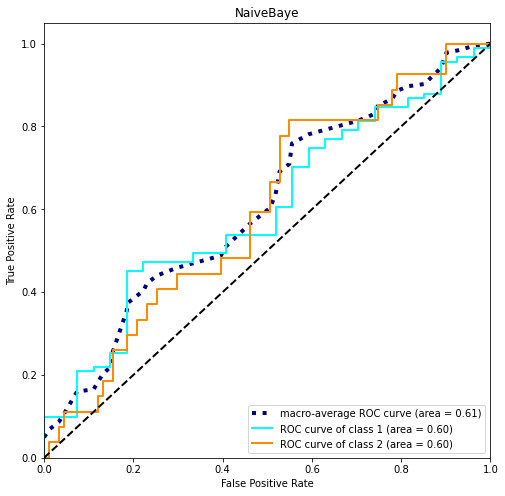

BaseLine : GradientBoosting
Running time: 0.12425708770751953 Seconds


,Positive,Negative,accuracy,macro avg,weighted avg
precision,0.81,0.50,0.77,0.65,0.74
recall,0.92,0.26,0.77,0.59,0.77
f1-score,0.86,0.34,0.77,0.60,0.74
support,91.00,27.00,0.77,118.00,118.00


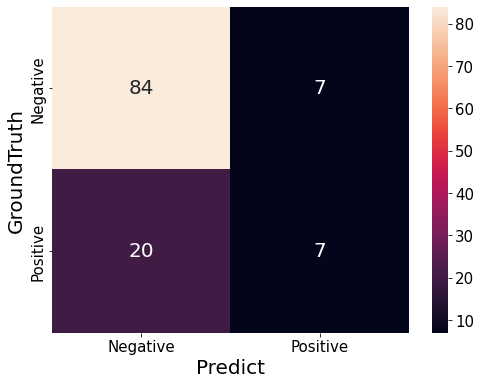

,BaslineName,Accuracy,Precision,MCC,PPV,NPV,Recall,F1,Time,TP,FP,TN,FN
0,GradientBoosting,0.771186,0.5,0.236862,0.5,0.807692,0.259259,0.341463,0.12,7,7,84,20


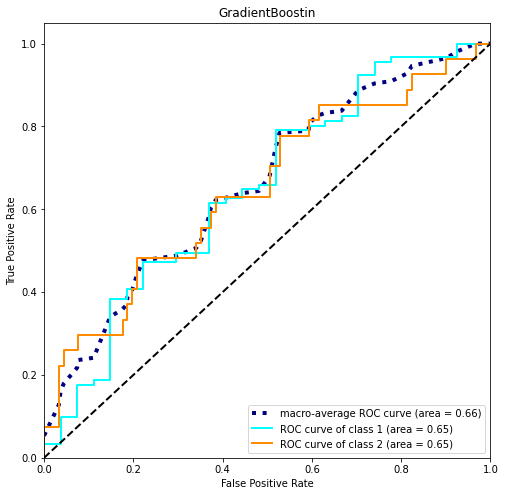

In [6]:
methods=['XGBoost','NaiveBayes','GradientBoosting']
method_compare=[]
label_column=['Positive','Negative']
for method in methods:
    path='save/'+method+'/'
    if not os.path.isdir(path):
        os.makedirs(path)
    print('='*100)
    print('BaseLine : '+method)
    groundtruth, predict, predictprob,item=evaluate(method,dataset)
    method_compare.append(item)
    # 导出报告
    matrix=metrics.confusion_matrix(groundtruth, predict)
    result=pd.DataFrame(matrix,columns=label_column,index=label_column)
    report=classification_report(groundtruth, predict,target_names=label_column,output_dict=True)
    report=round(pd.DataFrame(report).T,2)
    report.T.to_csv(path+'report.csv',encoding='utf_8')
    display(report.T)
    plot_matrix(groundtruth, predict,path+'./confusion_matrix.png')
    display(pd.DataFrame([method_compare[-1]]))
    ROC_plot(y_test,predictprob,path+method)

### 机器模型比对

In [9]:
pd.DataFrame(method_compare)

,BaslineName,Accuracy,Precision,MCC,PPV,NPV,Recall,F1,Time,TP,FP,TN,FN
0,XGBoost,0.762712,0.473684,0.255373,0.473684,0.818182,0.333333,0.391304,0.16,9,10,81,18
1,NaiveBayes,0.567797,0.260000,0.063661,0.260000,0.794118,0.481481,0.337662,0.01,13,37,54,14
2,GradientBoosting,0.771186,0.500000,0.236862,0.500000,0.807692,0.259259,0.341463,0.12,7,7,84,20
